## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

### Q1. 

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents. 

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [2]:
# --1--
df = pd.read_parquet('/Users/Daria/Documents/UVA/Foundations_of_ML/ds3001-labs/Phishing_Email.parquet')
# df.head()

# df['Email Text'].head()

tokens = df['Email Text'].str.split()
tokens.head()

0    [re, :, 6, ., 1100, ,, disc, :, uniformitarian...
1    [the, other, side, of, *, galicismos, *, *, ga...
2    [re, :, equistar, deal, tickets, are, you, sti...
3    [Hello, I, am, your, hot, lil, horny, toy., I,...
4    [software, at, incredibly, low, prices, (, 86,...
Name: Email Text, dtype: object

--2--

To clean the data I would get rid of common and filler words like 'and', 'the' etc because they are super common and used in basically every sentecnce in English. Getting rid of punctuation also seems like a good idea since that will be used (and reused) regardless of whether the email is a scam or not. Looking at how the punctuation is used might be helpful since emails with poor punctuation and grammar are probably more likely to be phising emails but because we are tokenizing the emailing punctuation usage would probably be hard to examine.

I would use PCA and probably multiple linear regression as the predictive algorithm using the most common words as the predicting variables. I would do PCA because that's what the assignment is about and linear regression seemed to make sense to me (and it's also one of the questions later on so it seems right).

### Q2. 

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [3]:
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

<Axes: >

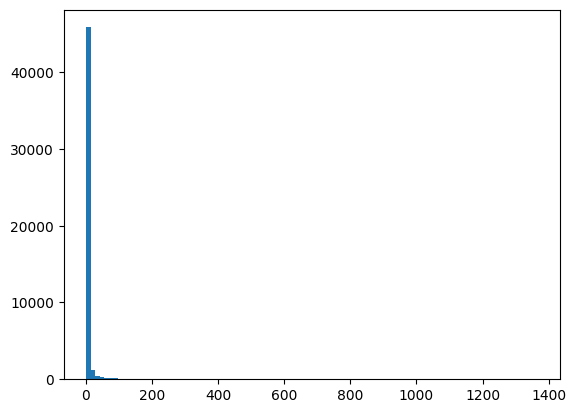

In [4]:
gdf = pd.DataFrame(token_freq,columns=['token','count'])
gdf['count'].hist(grid=False,bins=100)

In [5]:
gdf['count'].describe()

count    48691.000000
mean         5.687889
std         27.717476
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1365.000000
Name: count, dtype: float64

### Q3. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [6]:
df = pd.read_parquet('/Users/Daria/Documents/UVA/Foundations_of_ML/ds3001-labs/05_PCA/Phishing_clean.parquet')
y = df['Email Type']
X = df.drop('Email Type',axis=1)

# --1--
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=125)

In [7]:
# --2--
lin_reg = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lin_reg.predict(X_test)
y_hat_train_0 = lin_reg.predict(X_train)
print('training r-squared: ', r2_score(y_hat_train_0,y_train) )
print('testing r-squared: ', r2_score(y_hat_test_0,y_test) )

training r-squared:  0.6144860820476118
testing r-squared:  -0.000268384328047544


In [8]:
# --4--

rdf = pd.DataFrame({'variable':lin_reg.feature_names_in_ , 'value':lin_reg.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

,variable,value,abs
2223,1997-2002,-1.514772e+13,1.514772e+13
2224,pudge.,1.514772e+13,1.514772e+13
6,2002,1.448712e+13,1.448712e+13
96,000,-1.151892e+13,1.151892e+13
340,2005,-9.766916e+12,9.766916e+12
...,...,...,...
1052,soon,-1.974106e-04,1.974106e-04
319,thing,1.831055e-04,1.831055e-04
254,say,-1.220703e-04,1.220703e-04
512,science,-6.866455e-05,6.866455e-05


### Q4. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

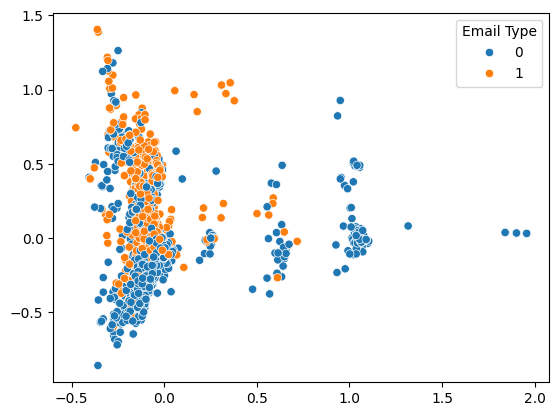

In [9]:
var = PCA(n_components=2).fit(X_train)
Z_train = var.transform(X_train)
Z_test = var.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

Assuming that 1 is 'true' and means that the email is a phishing email then we can see that the orange dots are the phishing emails. They tend to have a higher y value than x value so we can use that knowledge in relation to our predictions.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [10]:
var = PCA(n_components=2610).fit(X_train)
Z_train = var.transform(X_train)
Z_test = var.transform(X_test)
lin_reg2 = LinearRegression().fit(Z_train,y_train)
y_hat_test = lin_reg2.predict(Z_test)
y_hat_train = lin_reg2.predict(Z_train)

print('Train r-squared: ', r2_score(y_hat_train,y_train) )
print('Test r-squared: ', r2_score(y_hat_test,y_test) )    

Train r-squared:  0.6928975360963756
Test r-squared:  0.5873905973217189


### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

PCA allows us to sidestep the problem of multi-colinearity, interdependent variables, and analyze each one idependently. This is important because it means that the prediction doesn't become overly skewed based on bias instroduced from hidden variables.